# Traffic Management - Exploration

Contents: 

    1. Importing Tools and Dataset
    2. Data Visualisation
    3. Feature Engineering
    4. Model Testing 
    5. Bayesian Tuning

### Importing Tools and the Dataset

In [1]:
import pandas as pd
import numpy as np
# import geohash
from itertools import combinations
from sklearn.neighbors import NearestNeighbors
import time
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

In [511]:
# visualisation library
import matplotlib.pyplot as plt
import seaborn as sns

In [512]:
# reading the dataset
dataset = pd.read_csv("training.csv")

In [513]:
dataset.head()

,geohash6,day,timestamp,demand
0,qp03wc,18,20:0,0.020072
1,qp03pn,10,14:30,0.024721
2,qp09sw,9,6:15,0.102821
3,qp0991,32,5:0,0.088755
4,qp090q,15,4:0,0.074468


    The data shape

In [514]:
dataset.shape

(4206321, 4)

### Data Visualisation

    Data visualisation interpretation (shown below):
    ======================================================================
    
    1. From figure (a) and (c) for `hourly demand`, we tried to add new feature of `peak_hour` in which we add extra label 1 for the hour between 4 to 14 (mountain), 2 for the hour between 17 to 22 (valley) and else (transition)
    2. From the `average daily demand` (), we can see that there is a periodicity pattern going on every 7 day. Therefore, we performed feature engineering to convert `day` into `day_of_week` by changing the day into repetition of 1 into 7.
    3. 

In [515]:
dataset_plotter = dataset.copy()

In [516]:
# assigning hour and minute from the timestamp
# and removing timestamp column
dataset_plotter["hour"] = dataset_plotter["timestamp"].apply(lambda x: int(x.split(":")[0]))
dataset_plotter["minute"] = dataset_plotter["timestamp"].apply(lambda x: int(x.split(":")[1]))
dataset_plotter = dataset_plotter[["geohash6", "day", "hour", "minute", "demand"]]

In [517]:
dataset_plotter["day_of_week"] = dataset_plotter["day"].apply(lambda x: int(7) if x%7 == 0 else int(x%7))

In [518]:
dataset_plotter['key'] = 0
dataset_plotter = \
dataset_plotter[["key","geohash6"]].drop_duplicates().merge(dataset_plotter[["key","day"]].drop_duplicates(), how = "outer").\
merge(dataset_plotter[["key", "hour"]].drop_duplicates(), how = "outer").\
merge(dataset_plotter[["key", "minute"]].drop_duplicates(), how = "outer").drop(columns = ["key"]).\
merge(dataset_plotter.drop(columns = ["key"]), how = "left")

[]

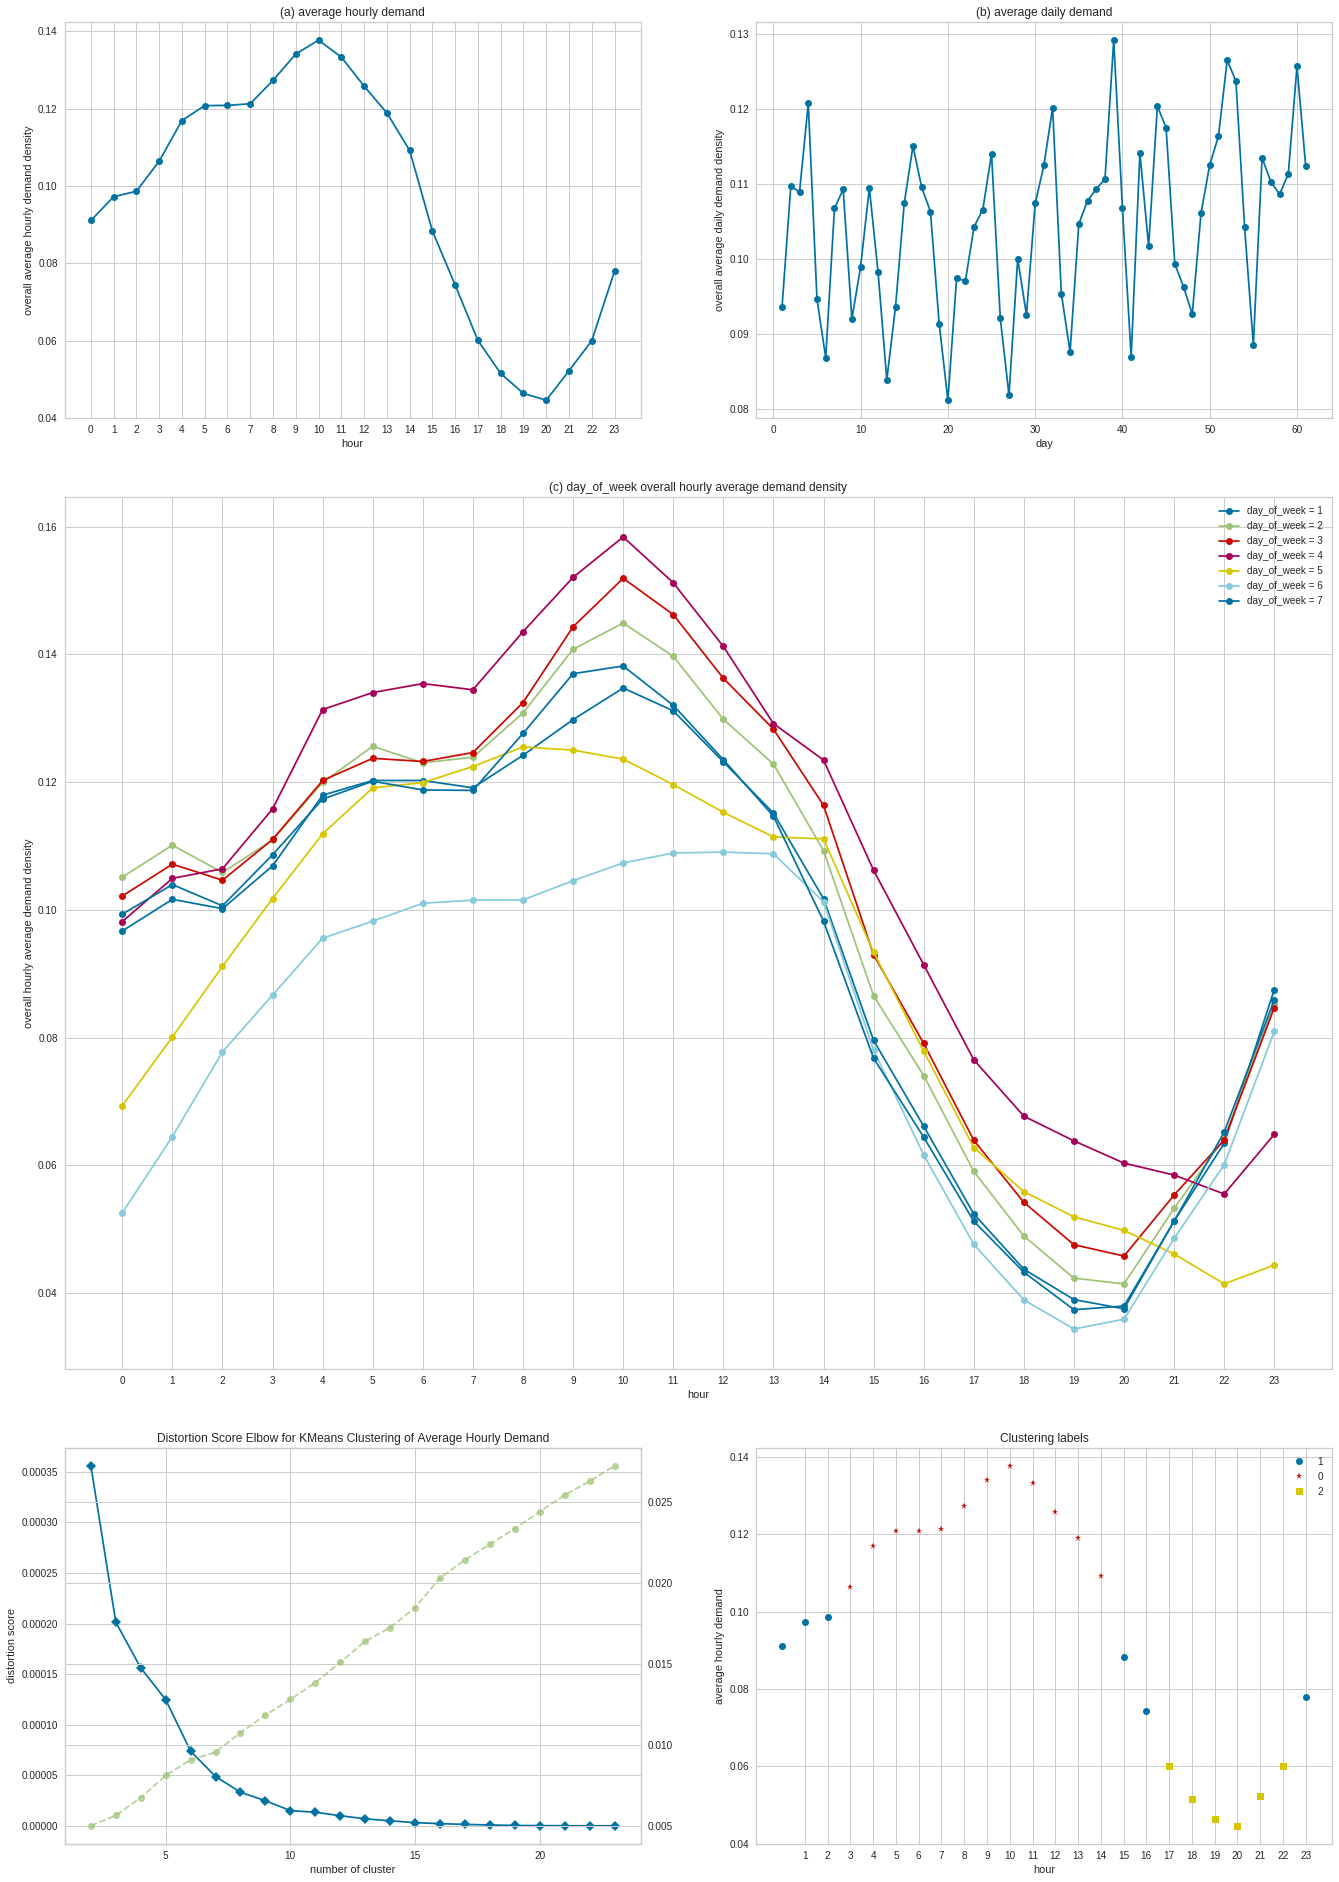

In [519]:
fig = plt.figure()
ax1 = fig.add_axes([0,0,1,1])

mean_demand_hourly = dataset_plotter.groupby("hour")["demand"].mean()
hour = mean_demand_hourly.index
average_demand_hourly = mean_demand_hourly.values

ax1.plot(hour, average_demand_hourly, "bo-")
ax1.set_title("(a) average hourly demand")
ax1.set_xlabel("hour")
ax1.set_ylabel("overall average hourly demand density")
ax1.set_xticks(hour)

ax2 = fig.add_axes([1.2,0,1,1])
mean_demand_daily = dataset_plotter.groupby("day")["demand"].mean()
day = mean_demand_daily.index
average_demand_daily = mean_demand_daily.values

ax2.plot(day, average_demand_daily, "bo-")
ax2.set_title("(b) average daily demand")
ax2.set_xlabel("day")
ax2.set_ylabel("overall average daily demand density")
# ax2.set_xticks(day)

ax3 = fig.add_axes([0, -2.4, 2.2, 2.2 ])
for i in range(1, 7 + 1):
    mean_demand_hourly = dataset_plotter.groupby(["day_of_week", "hour"], as_index = False)["demand"]\
    .mean().set_index("day_of_week").loc[i,:]
    hour = mean_demand_hourly["hour"]
    average_demand_hourly = mean_demand_hourly["demand"]
    ax3.plot(hour, average_demand_hourly, "o-", label = "day_of_week = {}".format(i))
ax3.set_xticks(hour)
ax3.legend()
ax3.set_xlabel("hour")
ax3.set_ylabel("overall hourly average demand density")
ax3.set_title("(c) day_of_week overall hourly average demand density")

# adding clustering for average hourly demand

ax4 = fig.add_axes([0,-3.6, 1 , 1])

from sklearn.cluster import KMeans

mean_hourly_demand = dataset_plotter.groupby("hour")["demand"].mean().values

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualiser = KElbowVisualizer(model, k=(2,len(mean_hourly_demand)), ax = ax4)

visualiser.fit(mean_hourly_demand.reshape(-1,1))
ax4.set_title("Distortion Score Elbow for KMeans Clustering of Average Hourly Demand")
ax4.set_xlabel("number of cluster")
ax4.set_ylabel("distortion score")

ax5 = fig.add_axes([1.2, -3.6, 1, 1])

mean_hourly_demand = dataset_plotter.groupby("hour")["demand"].mean().values
model = KMeans(n_clusters=3)
model.fit(mean_hourly_demand.reshape(-1,1))
patterns = ["r*", "bo", "ys", "^"]
labelset = set([])
for i, demand, label in zip(range(0, len(mean_hourly_demand)), mean_hourly_demand, model.labels_):
    if label in labelset:
        ax5.plot([i],[demand], patterns[label])
    else:
        ax5.plot([i],[demand], patterns[label], label = label)
        labelset.add(label)

ax5.set_xticks(list(range(1,24)))
ax5.set_xlabel("hour")
ax5.set_ylabel("average hourly demand")
ax5.set_title("Clustering labels")
ax5.legend()

plt.plot()

    from the clustering problem above, we can label each hour with clustering labels 0,1,2,3

In [520]:
clustered_hour = pd.DataFrame(list(zip(range(len(mean_hourly_demand)), model.labels_)),\
                              columns = ["hour", "clustered_hour"])
        

In [521]:
clustered_hour.head()

,hour,clustered_hour
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0


### Feature Engineering

    1. The `timestamp` column is in the form of `str`, we need to convert into new columns `hour` and `minute`.
    2. The data has unrecorded demand data which are empty. If at certain `region (geohash6)` in certain `hour` and at certain `minute` there is no demand data, we need to generate the features and assigning `demand` as 0.0
    3. Filling the missing rows in `demand` column in which are outliers.
    4. Filling the missing rows in `demand` column in which are no demand.
    
================================================================================================================

1. Converting `timestamp` values with new columns `hour` and `minute`

In [525]:
# assigning hour and minute from the timestamp
# and removing timestamp column
dataset["hour"] = dataset["timestamp"].apply(lambda x: int(x.split(":")[0]))
dataset["minute"] = dataset["timestamp"].apply(lambda x: int(x.split(":")[1]))
dataset = dataset[["geohash6", "day", "hour", "minute", "demand"]]

2. Generating non-mentioned features data that has 0.0 `demand` by creating all `feature combinations` through merging unique features (SQL like process)

In [526]:
dataset['key'] = 0
dataset = \
dataset[["key","geohash6"]].drop_duplicates().merge(dataset[["key","day"]].drop_duplicates(), how = "outer").\
merge(dataset[["key", "hour"]].drop_duplicates(), how = "outer").\
merge(dataset[["key", "minute"]].drop_duplicates(), how = "outer").drop(columns = ["key"]).\
merge(dataset.drop(columns = ["key"]), how = "left").fillna(0)

    the dataset after merging processes and the size shown below

In [527]:
dataset.head()

,geohash6,day,hour,minute,demand
0,qp03wc,18,20,0,0.020072
1,qp03wc,18,20,30,0.036756
2,qp03wc,18,20,15,0.061165
3,qp03wc,18,20,45,0.055304
4,qp03wc,18,14,0,0.178655


In [528]:
dataset.shape

(7782624, 5)

    The data shown has empty values recorded below in which consisting of 3576303 empty demand data, some are `demand` == 0  and few might be outliers

In [529]:
dataset.isnull().sum()

geohash6          0
day               0
hour              0
minute            0
demand      3576303
dtype: int64

    The data size

### Model Testing

In [530]:
# dataset.fillna(0, inplace = True)

In [531]:
dataset.head()

,geohash6,day,hour,minute,demand
0,qp03wc,18,20,0,0.020072
1,qp03wc,18,20,30,0.036756
2,qp03wc,18,20,15,0.061165
3,qp03wc,18,20,45,0.055304
4,qp03wc,18,14,0,0.178655


    Adding some extra features

In [532]:
performance_results = {}

In [545]:
def regressorModel(X, y,regressor = XGBRegressor(colsample_bytree = 0.4,
gamma = 0.21756976616440335,
 min_child_weight = 10.0,
 learning_rate = 0.05358746065589267,
 max_depth = 4,
 reg_alpha = 0.6870315939145919,
 reg_lambda = 0.24937700167665464,
 subsample = 0.845934912033431
)):
    regressor.fit(X,y)
    return regressor

In [546]:
# with open('all_params.txt', 'a') as the_file:
#     the_file.write('Hello\n')


start = time.time()

features = ['geohash6', 'day_of_week', 'hour', 'minute']
original_features = ["geohash6", "day", "hour", "minute", "day_of_week"]
# defining the minimum day and the maximum day

maximum = 60
minimum = 42

# defining the dataset copy

datasetcopy = dataset.copy()
datasetcopy.index = datasetcopy["day"]
datasetcopy.index = datasetcopy.index.set_names(["id"])

# with open("result002_features.txt", "a") as resultfile:
for i in range(minimum, maximum + 1):
    training_index = [j for j in range(i, min(i + 14, maximum + 1))]
    test_index = [j for j in range(i+14, min(i+19, maximum + 1))]
    if len(test_index) == 5:
        print("{})with indexes given below".format(i))
        print("="*60)
        print("training = {}".format(training_index))
        print("test = {}".format(test_index))

        training_set = datasetcopy.loc[training_index,:]
        test_set = datasetcopy.loc[test_index,:]

        # standardising the day into day of week

        training_set["day_of_week"] = training_set["day"].apply(lambda x: 7 if x%7 == 0 else x%7)
        test_set["day_of_week"] = test_set["day"].apply(lambda x: 7 if x%7 == 0 else x%7)
        
        # adding clustering and merging with the training and the testing data
        
        from sklearn.cluster import KMeans
        
        mean_hourly_demand = training_set.groupby("hour")["demand"].mean().values
        model = KMeans(n_clusters=3)
        model.fit(mean_hourly_demand.reshape(-1,1))
        clustered_hour = pd.DataFrame(list(zip(range(len(mean_hourly_demand)), model.labels_)),\
                              columns = ["hour", "clustered_hour"])
        
        
        training_set = training_set.merge(clustered_hour, how = "left")
        test_set = test_set.merge(clustered_hour, how = "left")
        
        features = features + ["clustered_hour"]

        for i in range(1, len(features)): # +1
            for comb in combinations(features, i):
                temp_df = training_set.copy().rename(columns = {"demand" : "-".join(list(comb)) + "(encoded)"}).\
                groupby(list(comb), as_index = False)\
                ["-".join(list(comb)) + "(encoded)"].mean()

                training_set = training_set.merge(temp_df, how = "left")
                test_set = test_set.merge(temp_df, how = "left")
                del temp_df

        X_train = training_set.copy().drop(columns = ["demand"] + original_features)
        y_train = training_set.copy()["demand"]
        X_test = test_set.copy().drop(columns = ["demand"] + original_features)
        y_test = test_set.copy()["demand"]

#         regressor = LinearRegression()
#         regressor = Lasso(alpha = 0.000302)
#         regressor.fit(X_train, y_train)
        regressor = regressorModel(X = X_train.values, y = y_train.values.reshape(-1,1))
        y_pred = regressor.predict(X_test.values)
        r2test = r2_score(y_test.values.reshape(-1,1), y_pred)
        mse_test = mse(y_test.values.reshape(-1,1), y_pred)
        print("test r2_score = {}".format(r2test))
        print("mse test = {}".format(mse_test))
        y_train_pred = regressor.predict(X_train.values)
        r2train = r2_score(y_train.values.reshape(-1,1), y_train_pred)
        mse_train = mse(y_train.values.reshape(-1,1), y_train_pred)
        print("training r2_score = {}".format(r2train))
        print("mse train = {}".format(mse_train))
        print("="*60)
        
        if len(performance_results.get("mse_train", [])) == 0:
            performance_results["mse_train"] = [mse_train]
        else:
            performance_results["mse_train"].append(mse_train)
            
        if len(performance_results.get("mse_test", [])) == 0:
            performance_results["mse_test"] = [mse_test]
        else:
            performance_results["mse_test"].append(mse_test)
            
        if len(performance_results.get("r2train", [])) == 0:
            performance_results["r2train"] = [r2train]
        else:
            performance_results["r2train"].append(r2train)
            
        if len(performance_results.get("r2test", [])) == 0:
            performance_results["r2test"] = [r2test]
        else:
            performance_results["r2test"].append(r2test)
        
#         performance_results["mse_test"] = performance_results.get("mse_test", [])+ [mse_test]
#         performance_results["r2_score_train"] = performance_results.get("r2_score_train", []) + [r2train]
#         performance_results["r2_score_test"] = performance_results.get("r2_score_test", [])+ [r2test]
#         print(list(comb))
#         resultfile.write("training indexes = {}\n".format(training_index))
#         resultfile.write("test indexes = {}\n".format(test_index))

#         resultfile.write("train r2_score = {}\n".format(r2train))
#         resultfile.write("test r2_score = {}\n".format(r2test))
        
        
        

#         break
del datasetcopy
end = time.time()
print("time taken {} seconds".format(end - start))

42)with indexes given below
training = [42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55]
test = [56, 57, 58, 59, 60]
test r2_score = 0.9042660125593188
mse test = 0.0018549731665878308
training r2_score = 0.9460075492885873
mse train = 0.0009753174782183705
time taken 179.1513810157776 seconds


In [538]:
for key in performance_results:    
    print("the average {} of XGBoost model with all parameters including the optimised hyperparameters is {}".format(key, \
            np.mean(performance_results[key])))
    
# before fixing the outliers

# the average mse_train of XGBoost model with all parameters including the optimised hyperparameters is 0.0008995937430955566
# the average mse_test of XGBoost model with all parameters including the optimised hyperparameters is 0.0018080296550959652
# the average r2train of XGBoost model with all parameters including the optimised hyperparameters is 0.9434424529735495
# the average r2test of XGBoost model with all parameters including the optimised hyperparameters is 0.8908174955863986

# after fixing the outliers

# the average mse_train of XGBoost model with all parameters including the optimised hyperparameters is 0.0008942109380061043
# the average mse_test of XGBoost model with all parameters including the optimised hyperparameters is 0.0018192026050899473
# the average r2train of XGBoost model with all parameters including the optimised hyperparameters is 0.9436702984288929
# the average r2test of XGBoost model with all parameters including the optimised hyperparameters is 0.8889829695395637

the average mse_train of XGBoost model with all parameters including the optimised hyperparameters is 0.001211523167156611
the average mse_test of XGBoost model with all parameters including the optimised hyperparameters is 0.0017090505357733542
the average r2train of XGBoost model with all parameters including the optimised hyperparameters is 0.9329314747768808
the average r2test of XGBoost model with all parameters including the optimised hyperparameters is 0.9117969868921719


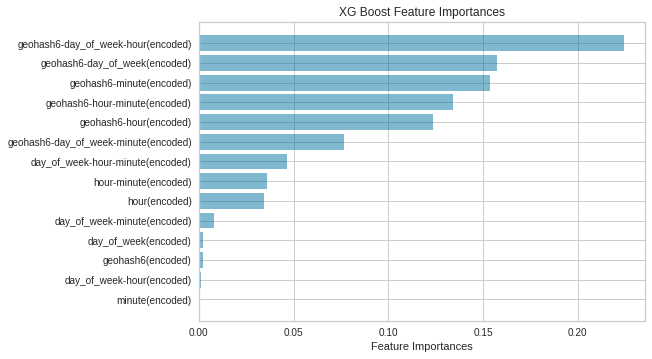

In [539]:
importances = pd.DataFrame({"features": X_train.columns, "feature_importances": regressor.feature_importances_})\
                .sort_values(by = "feature_importances")

objects = importances["features"].values
y_pos = np.arange(len(objects))
importance_values = importances["feature_importances"].values

plt.barh(y_pos, importance_values, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Feature Importances')
plt.title('XG Boost Feature Importances')

plt.show()

### Bayesian Tuning

In [555]:
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

In [556]:
# set up hyperparameter space
space = [Real(0.4, 0.8, name='colsample_bytree'),
         Real(0.0, 0.3, name='gamma'),
         Real(1.5, 10, name='min_child_weight'),
         Real(0.001, 1.0, name='learning_rate'), 
         Integer(3,5, name = "max_depth"), 
#          Integer([10000], name = "n_estimators"),
         Real(1e-5, 0.75, name = "reg_alpha"), 
         Real(1e-5, 0.45, name = "reg_lambda"),
         Real(0.6, 0.95, name = "subsample")
         ]

In [559]:
regressor = XGBRegressor()

@use_named_args(space)
def objective(**params):
    regressor.set_params(**params)
    regressor.fit(X_train, y_train.values.reshape(-1,1))
    y_pred = regressor.predict(X_test)
    return mse(y_test, y_pred)

In [560]:
reg_gp = gp_minimize(objective, space, verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 144.6682
Function value obtained: 0.0020
Current minimum: 0.0020
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 138.5451
Function value obtained: 0.0020
Current minimum: 0.0020
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 140.4900
Function value obtained: 0.0020
Current minimum: 0.0020
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 181.0822
Function value obtained: 0.0020
Current minimum: 0.0020
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 240.1438
Function value obtained: 0.0020
Current minimum: 0.0020
Iteration No: 6 started. 

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 109.4083
Function value obtained: 0.0020
Current minimum: 0.0019
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 265.5716
Function value obtained: 0.0020
Current minimum: 0.0019
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 184.2927
Function value obtained: 0.0020
Current minimum: 0.0019
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 155.8359
Function value obtained: 0.0020
Current minimum: 0.0019
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 248.0416
Function value obtained: 0.0020
Current minimum: 0.0019
Iteration No: 46 st

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 183.4306
Function value obtained: 0.0020
Current minimum: 0.0019
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 202.6453
Function value obtained: 0.0020
Current minimum: 0.0019
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 110.3292
Function value obtained: 0.0019
Current minimum: 0.0019
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 261.7125
Function value obtained: 0.0020
Current minimum: 0.0019
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 184.7727
Function value obtained: 0.0020
Current minimum: 0.0019
Iteration No: 86 st

### Best Bayesian Hyperparameter Tuning

    XGBoost with Parameters
    all features:
    "geohash6(encoded)",
    "day_of_week(encoded)", 
    "hour(encoded)", 
    "minute(encoded)",
    "geohash6-day_of_week(encoded)", etc
    
    (Exception: all coupling combinations of features - geohash6-day_of_week-hour-minute(encoded) is not included to avoid overfitting)
    
    colsample_bytree= 0.4
    gamma= 0.21756976616440335
    min_child_weight= 10.0
    learning_rate= 0.05358746065589267
    max_depth= 4
    reg_alpha= 0.6870315939145919
    reg_lambda= 0.24937700167665464
    subsample= 0.845934912033431

### Best Model (recorded in main.ipynb)

    XGBoost with hyperparameters:
        colsample_bytree= 0.4
        gamma= 0.21756976616440335
        min_child_weight= 10.0
        learning_rate= 0.05358746065589267
        max_depth= 4
        reg_alpha= 0.6870315939145919
        reg_lambda= 0.24937700167665464
        subsample= 0.845934912033431

     using features below (including the coupled features) and

In [2]:
features = ['geohash6', 'day_of_week', 'hour', 'minute']

In [3]:
j = 0
for i in range(1, len(features)): # +1
    for comb in combinations(features, i):
        j += 1
        print("feature {} : {}".format(j, "-".join(list(comb)) + "(encoded)"))

feature 1 : geohash6(encoded)
feature 2 : day_of_week(encoded)
feature 3 : hour(encoded)
feature 4 : minute(encoded)
feature 5 : geohash6-day_of_week(encoded)
feature 6 : geohash6-hour(encoded)
feature 7 : geohash6-minute(encoded)
feature 8 : day_of_week-hour(encoded)
feature 9 : day_of_week-minute(encoded)
feature 10 : hour-minute(encoded)
feature 11 : geohash6-day_of_week-hour(encoded)
feature 12 : geohash6-day_of_week-minute(encoded)
feature 13 : geohash6-hour-minute(encoded)
feature 14 : day_of_week-hour-minute(encoded)
